# Probabilistic generalized Polynomial Chaos Expansion

Saleh Rezaeiravesh, salehr@kth.se <br/>
SimEx/FLOW, Engineering Mechanics, KTH Royal Institute of Technology, Stockholm, Sweden

The aim of this notebook is to show how to use `UQit` for non-intrusive probabilistic gPCE (PPCE). In practice, we have the parameter samples and associated values of the model response. Therefore, we only want to construct the PPCE and estimate statistical moments of the model funtion due to the variablity of the uncertain parameters. This basically means much of the coding in the following examples is not required. The theory about PPCE can be studied from [Owen](https://ore.exeter.ac.uk/repository/handle/10871/29296?show=full) and [Rezaeiravesh et. al](https://arxiv.org/pdf/2007.07071.pdf).

In [1]:
import os
import sys
import numpy as np
import math as mt
import matplotlib
import matplotlib.pyplot as plt
sys.path.append(os.getenv("UQit"))
import ppce
import pce
import gpr_torch
import statsUQit
import analyticTestFuncs
import writeUQ
import reshaper
import sampling

### Example 1: PPCE for one uncertain parameter

Consider parameter $q\in \mathbb{Q}\subset\mathbb{R}$ which have a known distribution based on the standard gPCE. The explicit form of the simulator $f(q)$ is not known. However, the noisy observations are assumed to be generated as

$$
y=f(q)+\varepsilon
$$

where $\varepsilon\sim\mathcal{N}(0,\sigma^2)$. If $\sigma$ is fixed (iid samples), we have homoscedastic noise and if $\sigma$ is observation-dependent then the noise is heteroscedastic. 

In this example, we estimate $\mathbb{E}[f(q)]$ and $\mathbb{V}[f(q)]$ using PPCE approach. To this end:

  * Given training data $\mathcal{D}=\{(q^{(i)},y^{(i)})\}_{i=1}^n$, a GPR is constructed.
  * For each sample drawn from the GPR, we construct a gPCE. Repeating this for $m$ samples, through the use of Monte-Carlo approach stochastic estimates for $\mathbb{E}[f(q)]$ and $\mathbb{V}[f(q)]$ are made. 

First, we need functions to synthetically generate training samples

In [2]:
def simulator(x,fType,qInfo):
    """Simulator"""
    yEx=analyticTestFuncs.fEx1D(x,fType,qInfo).val
    return yEx
#
def noiseGen(n,noiseType):
    """
    Generate a 1D numpy array of the standard deviation of the observation noise
    """
    if noiseType=='homo': #homoscedastic noise
       sd=0.1   #(non-zero, to avoid instabilities)
       sdV=[sd]*n
       sdV=np.asarray(sdV)
    elif noiseType=='hetero': #heteroscedastic noise
       sdMin=0.02
       sdMax=0.2
       sdV=sdMin+(sdMax-sdMin)*np.linspace(0.0,1.0,n)
    return sdV
#
def trainData(xInfo,n,noiseType,trainSamplyType,distType,fType):
    """Create training data D={X,Y}"""
    X_=sampling.trainSample(sampleType=trainSampleType,GQdistType=distType,qInfo=xInfo,nSamp=n)
    x=X_.q
    sdV=noiseGen(n,noiseType)
    y=simulator(x,fType,xInfo) + sdV * np.random.randn(n)
    return x,y,sdV

Different Settings for the whole process are set as below:

In [3]:
distType='Unif'      #type of distribution of the parameter (Acc. gPCE rule)
trainSampleType='unifRand'   #how to draw the trainining samples, see trainSample in sampling.py
qInfo=[-2,2.5]     #info about the parameter
                    #if 'Unif', qInfo =[min(q),max(q)]
                    #if 'Norm', qInfo=[m,v] for q~N(m,v^2)
n=30            #number of training samples in GPR
noiseType='hetero'   #'homo'=homoscedastic, 'hetero'=heterscedastic
nGQtest=15         #number of test points (=Gauss quadrature nodes)
#GPR options
nIter_gpr=1000      #number of iterations in optimization of hyperparameters
lr_gpr   =0.2       #learning rate for the optimization of the hyperparameters
convPlot_gpr=True   #plot convergence of the optimization of the GPR hyperparameters
nMC=2000            #number of samples drawn from GPR surrogate to construct estimates 
                    #  for the moments of f(q)

Generate the synthetic training data

In [4]:
if distType=='Unif':
   fType='type1'
elif distType=='Norm':
   fType='type2'
qTrain,yTrain,noiseSdev=trainData(qInfo,n,noiseType,trainSampleType,distType,fType)

Construct the PPCE

... Probabilistic PCE for 1D input parameter.
...... GPR-hyperparameters Optimization, iter 100/1000 - loss: 0.189 - lengthsc: 0.539
...... GPR-hyperparameters Optimization, iter 200/1000 - loss: 0.126 - lengthsc: 0.535
...... GPR-hyperparameters Optimization, iter 300/1000 - loss: 0.125 - lengthsc: 0.533
...... GPR-hyperparameters Optimization, iter 400/1000 - loss: 0.124 - lengthsc: 0.531
...... GPR-hyperparameters Optimization, iter 500/1000 - loss: 0.123 - lengthsc: 0.528
...... GPR-hyperparameters Optimization, iter 600/1000 - loss: 0.122 - lengthsc: 0.526
...... GPR-hyperparameters Optimization, iter 700/1000 - loss: 0.122 - lengthsc: 0.524
...... GPR-hyperparameters Optimization, iter 800/1000 - loss: 0.121 - lengthsc: 0.522
...... GPR-hyperparameters Optimization, iter 900/1000 - loss: 0.118 - lengthsc: 0.521
...... GPR-hyperparameters Optimization, iter 1000/1000 - loss: 0.030 - lengthsc: 0.522


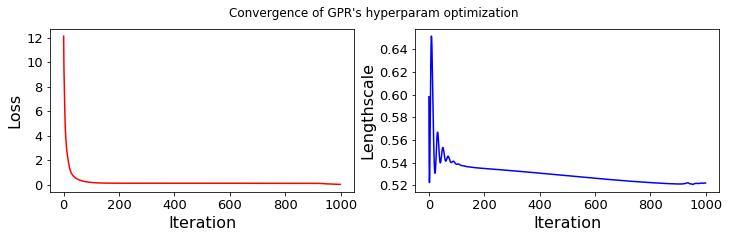

...... ppce repetition for finding samples of the PCE coefficients, iter = 200/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 400/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 600/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 800/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 1000/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 1200/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 1400/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 1600/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 1800/2000
...... ppce repetition for finding samples of the PCE coefficients, iter = 2000/2000


In [5]:
ppceDict={'nGQtest':nGQtest,'qInfo':qInfo,'distType':distType,
          'nIter_gpr':nIter_gpr,'lr_gpr':lr_gpr,'convPlot_gpr':convPlot_gpr,'nMC':nMC}
ppce_=ppce.ppce(qTrain,yTrain,noiseSdev,ppceDict)
fMean_samples=ppce_.fMean_samps
fVar_samples=ppce_.fVar_samps
optOut=ppce_.optOut

Compare the exact moments with estimated values by ppce

In [6]:
fEx_=analyticTestFuncs.fEx1D(qTrain,fType,qInfo)
fEx_.moments(qInfo)
fMean_ex=fEx_.mean
fVar_ex=fEx_.var
fMean_mean=fMean_samples.mean()
fMean_sdev=fMean_samples.std()
fVar_mean=fVar_samples.mean()
fVar_sdev=fVar_samples.std()
print(writeUQ.printRepeated('-', 80))
print('>> Exact mean(f) = %g' %fMean_ex)
print('   ppce estimated: E[mean(f)] = %g , sdev[mean(f)] = %g' %(fMean_mean,fMean_sdev))
print('>> Exact Var(f) = %g' %fVar_ex)
print('   ppce estimated: E[Var(f)] = %g , sdev[Var(f)] = %g' %(fVar_mean,fVar_sdev))

--------------------------------------------------------------------------------
>> Exact mean(f) = 10.948
   ppce estimated: E[mean(f)] = 10.951 , sdev[mean(f)] = 0.0244819
>> Exact Var(f) = 3.18976
   ppce estimated: E[Var(f)] = 3.1468 , sdev[Var(f)] = 0.0694071


Plot histogram and PDF (probability density function) of the mean and variance distribution

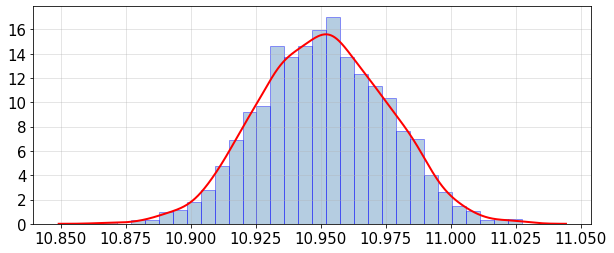

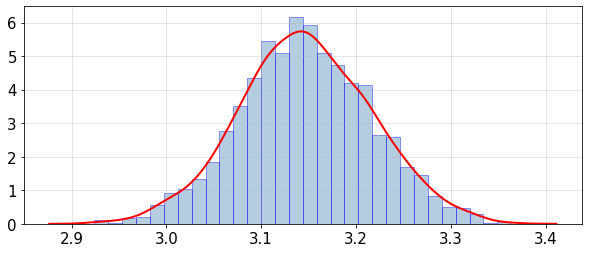

In [7]:
statsUQit.pdfFit_uniVar(fMean_samples,True,[])
statsUQit.pdfFit_uniVar(fVar_samples,True,[])

Plot the GPR surrogate along with response from the exact simulator

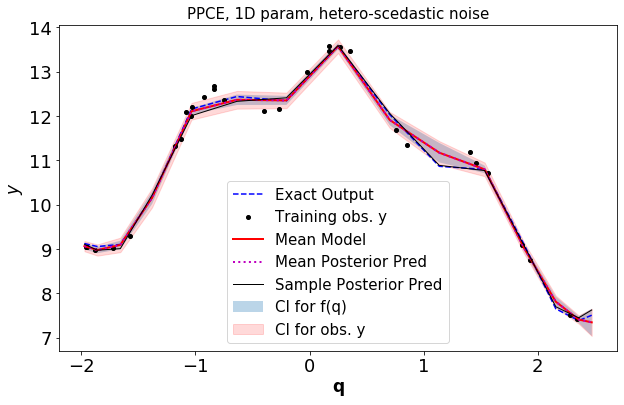

In [8]:
pltOpts={'title':'PPCE, 1D param, %s-scedastic noise'%noiseType}
gpr_torch.gprPlot(pltOpts).torch1d(optOut['post_f'],optOut['post_obs'],qTrain,yTrain,
        optOut['qTest'][0],simulator(optOut['qTest'][0],fType,qInfo))

### Example 2: PPCE for two parameters

Using `UQit`, we can apply PPCE to any number of uncertain parameters. Here, we consider two uncertain parameters $q_1\in\mathbb{Q}_1$ and $q_2\in\mathbb{Q}_2$, and use PPCE to estimate statistical moments of $f(\mathbf{q})$ for $\mathbf{q}\in \mathbb{Q}_1 \bigotimes \mathbb{Q}_1$.

First, the functions for generating the synthtic training samples.

In [9]:
def fEx(p,sampleType,n,qInfo,fExName):
    """Generate synthetic training data"""
    #  (a) xTrain
    nSamp=n[0]*n[1]
    xi=[]
    q=[]
    qBound=[]
    if sampleType[0]=='LHS' and sampleType[1]=='LHS':
       if distType==['Unif']*p:
          qBound=qInfo
          xi=sampling.LHS_sampling(nSamp,[[-1,1]]*p)
          xTrain=np.zeros((nSamp,p))
          for i in range(p):
              xTrain[:,i]=pce.pce.mapFromUnit(xi[:,i],qBound[i])
          yTrain=analyticTestFuncs.fEx2D(xTrain[:,0],xTrain[:,1],fExName,'comp').val
       else:
          raise ValueError("LHS works only when all q have 'Unif' distribution.")
    else:
       for i in range(p):
           samps=sampling.trainSample(sampleType=sampleType[i],GQdistType=distType[i],
                   qInfo=qInfo[i],nSamp=n[i])
           q.append(samps.q)
       xTrain=reshaper.vecs2grid(q)
       yTrain=analyticTestFuncs.fEx2D(q[0],q[1],fExName,'tensorProd').val
    return xTrain,yTrain
#
def trainDataGen(p,sampleType,n,qInfo,fExName,noiseType):
    """Generate synthetic training data"""
    #  (a) xTrain and noise-free yTrain
    xTrain,yTrain_noiseFree=fEx(p,sampleType,n,qInfo,fExName)
    nSamp=xTrain.shape[0]
    #  (b) set the sdev of the observation noise
    noiseSdev=noiseGen(nSamp,noiseType,xTrain,fExName)
    #  (c) Training data
    yTrain=yTrain_noiseFree+noiseSdev*np.random.randn(nSamp)
    return xTrain,yTrain,noiseSdev,yTrain_noiseFree
#
def noiseGen(n,noiseType,xTrain,fExName):
    """Generate a 1D numpy array of standard deviation of the observation noise"""
    if noiseType=='homo':
       sd=0.2   #(non-zero, to avoid instabilities)
       sdV=sd*np.ones(n)
    elif noiseType=='hetero':
       sdV=0.1*(analyticTestFuncs.fEx2D(xTrain[:,0],xTrain[:,1],fExName,'comp').val+0.001)
    return sdV

Settings:

In [10]:
#settings for parameters and data
qInfo=[[-2,2],[-2,3]]    #info about the parameter
                         #if 'Unif', qInfo =[min(q),max(q)]
                         #if 'Norm', qInfo=[m,v] for q~N(m,v^2)
distType=['Unif','Unif']    #distribution type of parameters
fExName='type1'          #name of simulator to generate synthetic dat
                         #see analyticTestFuncs.fEx2D()
trainSampleType=['LHS','LHS']   #sampling type, see trainSample in sampling.py
n=[10,12]               #number of training samples for each parameter.
                        #note: n[0]*n[1]<128, due to GpyTorch
noiseType='hetero'      #type of observation noise
                        #'homo'=homoscedastic, 'hetero'=heterscedastic
#options for GPR
nIter_gpr=1000      #number of iterations in optimization of hyperparameters
lr_gpr   =0.1       #learning rate for the optimization of the hyperparameters
convPlot_gpr=True   #plot convergence of optimization of the GPR hyperparameters
#options for Gauss quadrature test nodes
nGQtest=[18,18]     #number of test samples in each param dimension
nMC=1000             #number of samples drawn from GPR surrogate to construct estimates 
                    # for the moments of f(q)

Generate synthetic training data

In [11]:
p=len(distType)   
qTrain,yTrain,noiseSdev,yTrain_noiseFree=trainDataGen(p,trainSampleType,n,qInfo,fExName,noiseType)

Construct the PPCE

... Probabilistic PCE for 2-D input parameter.
...... GPR-hyperparameters Optimization, iter 100/1000 - loss: 0.761  lengthscales=1.056 1.028 
...... GPR-hyperparameters Optimization, iter 200/1000 - loss: 0.753  lengthscales=1.125 1.098 
...... GPR-hyperparameters Optimization, iter 300/1000 - loss: 0.751  lengthscales=1.164 1.137 
...... GPR-hyperparameters Optimization, iter 400/1000 - loss: 0.749  lengthscales=1.190 1.164 
...... GPR-hyperparameters Optimization, iter 500/1000 - loss: 0.749  lengthscales=1.208 1.182 
...... GPR-hyperparameters Optimization, iter 600/1000 - loss: 0.749  lengthscales=1.222 1.196 
...... GPR-hyperparameters Optimization, iter 700/1000 - loss: 0.749  lengthscales=1.232 1.206 
...... GPR-hyperparameters Optimization, iter 800/1000 - loss: 0.748  lengthscales=1.239 1.214 
...... GPR-hyperparameters Optimization, iter 900/1000 - loss: 0.748  lengthscales=1.245 1.219 
...... GPR-hyperparameters Optimization, iter 1000/1000 - loss: 0.748  lengthscales=1.249

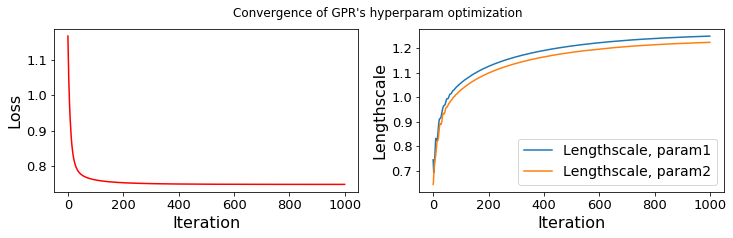

...... ppce repetition for finding samples of the PCE coefficients, iter = 100/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 200/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 300/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 400/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 500/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 600/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 700/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 800/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 900/1000
...... ppce repetition for finding samples of the PCE coefficients, iter = 1000/1000


In [12]:
ppceDict={'nGQtest':nGQtest,'qInfo':qInfo,'distType':distType,'nIter_gpr':nIter_gpr,
          'lr_gpr':lr_gpr,'convPlot_gpr':convPlot_gpr,'nMC':nMC}
ppce_=ppce.ppce(qTrain,yTrain,noiseSdev,ppceDict)
optOut=ppce_.optOut
fMean_samples=ppce_.fMean_samps
fVar_samples=ppce_.fVar_samps

Estimate reference mean and varaiance of $f(q)$ using Monte-Carlo approach

In [13]:
nMC2=100000
qMC=[]
for i in range(p):
    if distType[i]=='Unif':
       sampleType_='unifRand'
    elif distType[i]=='Norm':
       sampleType='normRand'
    samps=sampling.trainSample(sampleType=sampleType_,GQdistType=distType[i],
          qInfo=qInfo[i],nSamp=nMC2)
    qMC.append(samps.q)
fVal_mc=analyticTestFuncs.fEx2D(qMC[0],qMC[1],fExName,'comp').val
fMean_mc=np.mean(fVal_mc)
fVar_mc=np.mean(fVal_mc**2.)-fMean_mc**2.

Postprocess, plots, and comparison between the estimated moments of $f(q)$ with the reference values.

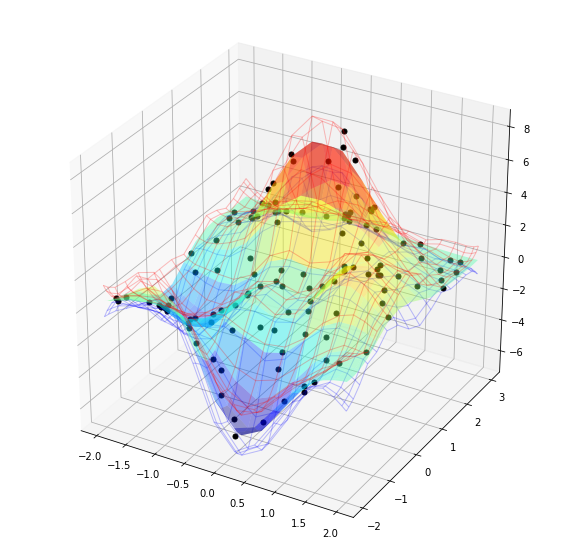

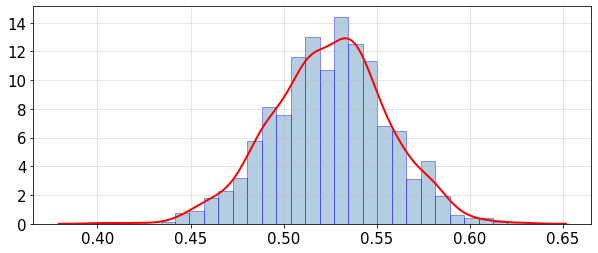

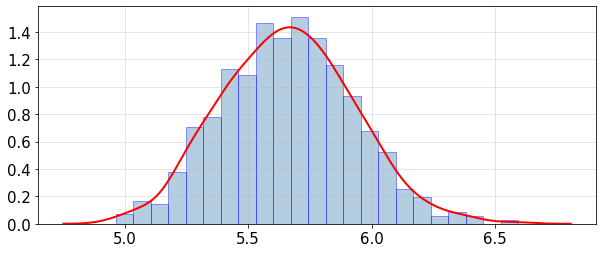

--------------------------------------------------------------------------------
Reference mean(f) = 0.539947
PPCE estimated: E[mean(f)] = 0.524599 , sdev[mean(f)] = 0.0307491
Reference var(f) = 5.99112
PPCE estimated: E[var(f)] = 5.6605 , sdev[var(f)] = 0.266139


In [14]:
#   (a) plot the exact and GPR response surfaces
gpr_torch.gprPlot().torch2d_3dSurf(qTrain,yTrain,optOut['qTest'],optOut['post_obs'])
#   (b) plot histogram and fitted pdf of the mean and variance distributions
statsUQit.pdfFit_uniVar(fMean_samples,True,[])
statsUQit.pdfFit_uniVar(fVar_samples,True,[])
#   (c) compare the reference moments with the estimated values by ppce
fMean_mean=fMean_samples.mean()
fMean_sdev=fMean_samples.std()
fVar_mean=fVar_samples.mean()
fVar_sdev=fVar_samples.std()
print(writeUQ.printRepeated('-', 80))
print('Reference mean(f) = %g' %fMean_mc)
print('PPCE estimated: E[mean(f)] = %g , sdev[mean(f)] = %g' %(fMean_mean,fMean_sdev))
print('Reference var(f) = %g' %fVar_mc)
print('PPCE estimated: E[var(f)] = %g , sdev[var(f)] = %g' %(fVar_mean,fVar_sdev))